In [20]:
import pandas as pd

import mix as mix
import db_column_name as db

import numpy as np
pd.set_option('precision', 10)

import scipy.sparse
import pickle
import xgboost as xgb

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 7,5

# offset can be 9, 21. 33, 45, 57, 69
cn = db.ColumnName()

target_minT = pd.read_csv('./data/31286_103.csv')
mix.set_index_date(target_minT, cn.date)
target_minT = target_minT.sort_index()

X = pd.read_csv('./data/character_31286.csv')
mix.set_index_date(X, cn.date)
X = X.sort_index()

X = X.drop([cn.point], axis=1)
X = X[[x for x in X.columns if 'avg' in x or 
       x == cn.offset]]


# X = X[X[cn.offset] == 69]
# X = mix.year_less_eq(X, 2016)

X = X.groupby([X.index.year, 
           X.index.month, 
           X.index.day]).mean()

a = pd.DataFrame(X.index.tolist(), 
                 columns=['year','month','day'])
X.index = pd.to_datetime(a)

X = X.drop([cn.offset], axis=1)

target_minT.index = target_minT.index.round('D')

X[cn.value] = target_minT
X = mix.clean_dataset(X)

print(X.shape)

(1810, 55)


(1345, 56)


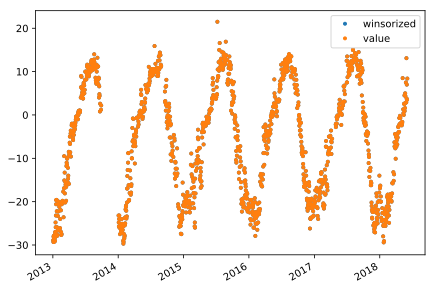

In [21]:
X['winsorized'] = X[cn.value]
for index, row in X.iterrows(): 
    
    offset_day = pd.to_timedelta(5, unit='day')
    start_date = index - offset_day
    end_date = index + offset_day
    
    s = X.iloc[(X.index >= start_date) & (X.index <= end_date)]
    s = s[[cn.value]]
    
    q = s.quantile([0.05, 0.95])
    
    v = row[cn.value]
    if (v < q.iloc[0, 0] or v > q.iloc[1, 0]):
        X.drop([index], inplace=True)
    
print(X.shape)
X[['winsorized', cn.value]].plot(style='.')

In [22]:
X[cn.value] = X['winsorized']
X = X.drop(['winsorized'], axis=1)

Fit timeSeriesSplit
Train size : 225 and test size : 224
Mean squared error on train 0.89640 and test 21.94342
Mean absolute error on train 0.72677 and test 3.49381
Median absolute error on train 0.55354 and test 2.53459
Train size : 449 and test size : 224
Mean squared error on train 1.18607 and test 14.72711
Mean absolute error on train 0.83279 and test 2.90844
Median absolute error on train 0.66801 and test 2.23685
Train size : 673 and test size : 224
Mean squared error on train 1.30625 and test 35.84267
Mean absolute error on train 0.87408 and test 4.01879
Median absolute error on train 0.69068 and test 2.45086
Train size : 897 and test size : 224
Mean squared error on train 1.79224 and test 44.07720
Mean absolute error on train 1.00238 and test 5.28693
Median absolute error on train 0.76190 and test 4.84942
Train size : 1121 and test size : 224
Mean squared error on train 2.51744 and test 15.85543
Mean absolute error on train 1.19508 and test 3.20372
Median absolute error on train

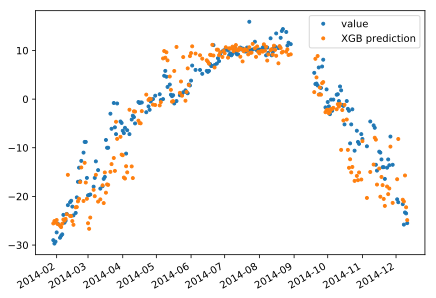

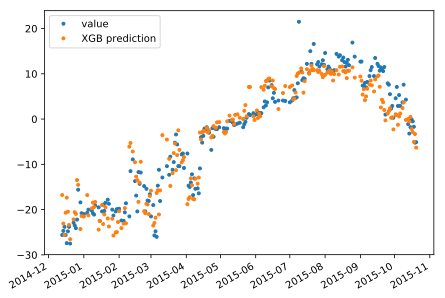

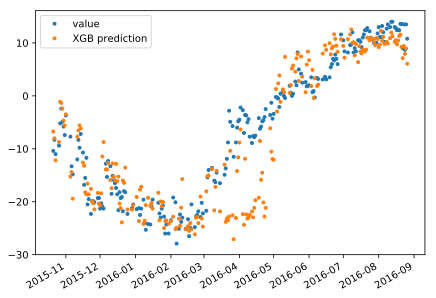

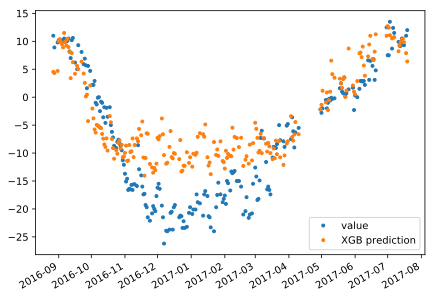

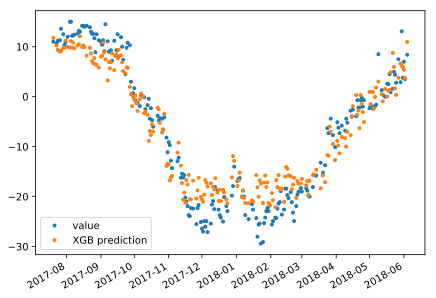

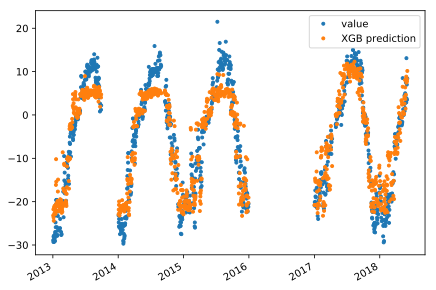

In [24]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate

def fit(params, X, target, label_v):   
    print("Fit timeSeriesSplit")
    for train_index, test_index in TimeSeriesSplit(5).split(X):   
#         test_index = [i for i in range(0, X.shape[0]) if i not in train_index]  

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        target_train, target_test = target.iloc[train_index], target.iloc[test_index]
        print("Train size : {} and test size : {}".format(X_train.shape[0], X_test.shape[0]))
        
        reg = xgb.XGBRegressor(**params)

        reg.fit(X_train, target_train)

        target_test.loc[:, 'XGB prediction'] = reg.predict(X_test)
        target_train.loc[:, 'XGB prediction'] = reg.predict(X_train)
    
        mix.print_mean(target_test, target_train, label_v, 'XGB prediction') 
        target_test.plot(style=".")
        
def fit_on_year(params, X_clear, target_minT, year):
    print("Fir on one year")
    X_train, X_test = X_clear[X_clear.index.year == year], X_clear[X_clear.index.year != year]
    target_train, target_test = target_minT.loc[X_train.index], target_minT.loc[X_test.index]
    print("Train size : {} and test size : {}".format(X_train.shape[0], X_test.shape[0]))

    reg = xgb.XGBRegressor(**params)

    reg.fit(X_train, target_train)

    target_test.loc[:, 'XGB prediction'] = reg.predict(X_test)
    target_train.loc[:, 'XGB prediction'] = reg.predict(X_train)
    mix.print_mean(target_test, target_train, cn.value, 'XGB prediction') 
    
    target_test.plot(style=".")

def simple_predict():
    default_params = {
        'verbosity':0,
        'max_depth': 4,

    #     'learning_rate': 0.05,
        'min_child_weight': 7,
    #     'subsample':0.8, 
    #     'colsample_bytree':0.8,
        'gamma': 7,
    }

    X_clear, target_minT = mix.getTarget(X)
    fit(default_params, X_clear, target_minT, cn.value)


    params_one_year = {
        'verbosity':0,
        'max_depth': 4,

        'learning_rate': 0.05,
        'min_child_weight': 6,
    #     'subsample':0.8, 
    #     'colsample_bytree':0.8,
    #     'gamma': 7,
    }
    fit_on_year(params_one_year, X_clear, target_minT, 2016)
    
simple_predict()

(599, 55)
Fit timeSeriesSplit
Train size : 104 and test size : 99
Mean squared error on train 0.00767 and test 19.91244
Mean absolute error on train 0.06440 and test 3.38478
Median absolute error on train 0.05147 and test 2.44577
Train size : 203 and test size : 99
Mean squared error on train 0.04066 and test 12.21785
Mean absolute error on train 0.14934 and test 2.76867
Median absolute error on train 0.11931 and test 2.16947
Train size : 302 and test size : 99
Mean squared error on train 0.14657 and test 36.08373
Mean absolute error on train 0.28860 and test 3.94038
Median absolute error on train 0.22005 and test 2.34883
Train size : 401 and test size : 99
Mean squared error on train 0.32860 and test 49.38307
Mean absolute error on train 0.43258 and test 5.52831
Median absolute error on train 0.33395 and test 4.83066
Train size : 500 and test size : 99
Mean squared error on train 0.55397 and test 16.05216
Mean absolute error on train 0.56572 and test 3.36985
Median absolute error on t

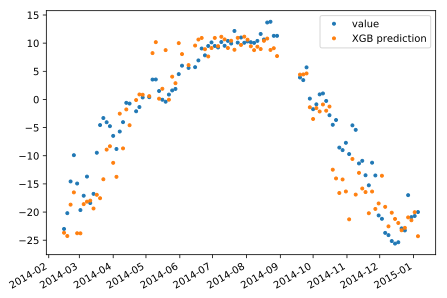

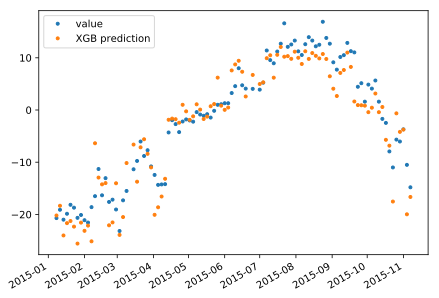

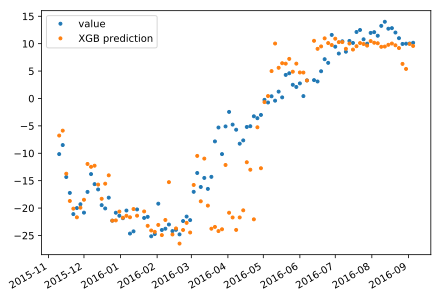

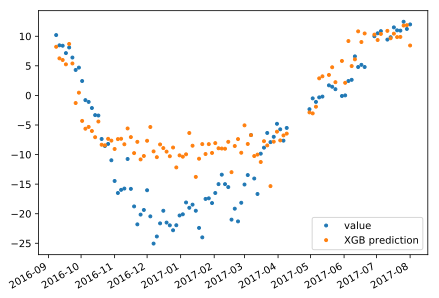

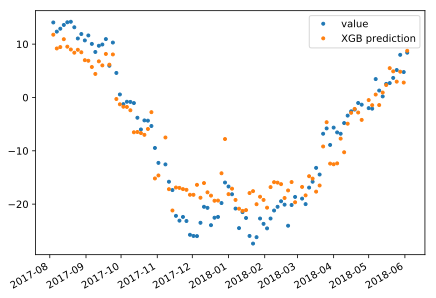

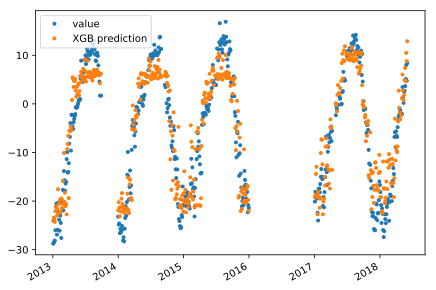

In [25]:
def predict_mean():

    X_ = X.resample('3D').mean()
    X_ = mix.clean_dataset(X_)
    print(X_.shape)

    params_mean = {
        'verbosity':0,
        'max_depth': 4,

#         'learning_rate': 0.05,
        'min_child_weight': 6,
    #     'subsample':0.9, 
    #     'colsample_bytree':0.8,
#         'gamma': 7,
    }

    X_3mean, target_3mean = mix.getTarget(X_)
    fit(params_mean, X_3mean, target_3mean, cn.value)

    fit_on_year(params_mean, X_3mean, target_3mean, 2016)
    
predict_mean()

Train size : 225 and test size : 224
Mean squared error on train 0.03657 and test 19.54839
Mean absolute error on train 0.13919 and test 3.36309
Median absolute error on train 0.09532 and test 2.63001
Train size : 449 and test size : 224
Mean squared error on train 0.27949 and test 16.55754
Mean absolute error on train 0.39096 and test 3.02618
Median absolute error on train 0.28331 and test 2.35469
Train size : 673 and test size : 224
Mean squared error on train 0.57228 and test 19.27323
Mean absolute error on train 0.56790 and test 3.28108
Median absolute error on train 0.44810 and test 2.47681
Train size : 897 and test size : 224
Mean squared error on train 0.92275 and test 54.36131
Mean absolute error on train 0.70875 and test 5.94690
Median absolute error on train 0.52685 and test 5.16311
Train size : 1121 and test size : 224
Mean squared error on train 1.22567 and test 13.80456
Mean absolute error on train 0.83770 and test 3.03525
Median absolute error on train 0.63085 and test 2.

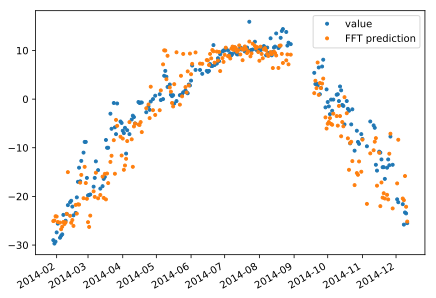

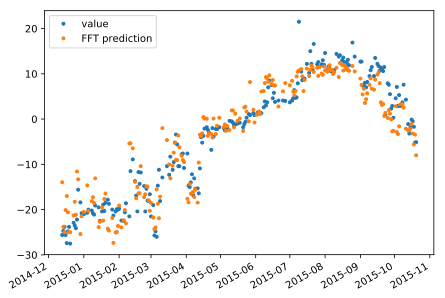

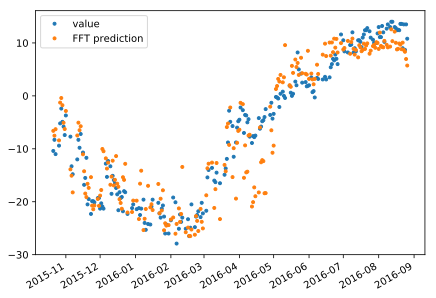

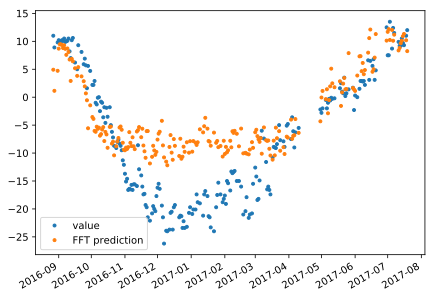

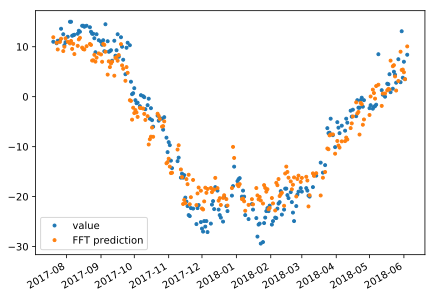

In [26]:
from scipy.fftpack import fft, ifft
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def fft_(X):
    N = X.shape[0]
    y = X[[cn.value]]
    y.reset_index(inplace=True)
    
    Y = fft(y[[cn.value]].values)
    index = np.fft.fftfreq(N)
    
    amplit_Y  = np.abs(Y)
    phase_Y = np.angle(Y)

    fft_target = pd.DataFrame(np.hstack((amplit_Y, phase_Y)), columns=['amplitude', 'phase']) 
    fft_target.loc[:, cn.date] = y['index']
    fft_target.set_index(index, inplace=True)
    fft_X = X.set_index(index)
    
    return fft_X, fft_target

def com(radii, angles):
    return radii * np.around(np.exp(1j*angles), 10)

def complex_(r, a):
    Y_ = np.array(com(r, a).values)
    Y_ = Y_.reshape((Y_.size, 1))
    return Y_

def predict_fft():
    fft_X, fft_target = fft_(X)
    fft_X.drop([cn.value], inplace=True, axis=1)
    real_X, real_target = mix.getTarget(X)



    params = {
        'verbosity':0,
        'max_depth': 5,

        'learning_rate': 0.09,
        'min_child_weight': 6,
    #     'subsample':0.8, 
    #     'colsample_bytree':0.8,
    #     'gamma': 12,
    }

    for train_index, test_index in TimeSeriesSplit(5).split(fft_X):
#         test_index = [i for i in range(0, fft_X.shape[0]) if i not in train_index]  

        fft_X_train, fft_X_test = fft_X.iloc[train_index], fft_X.iloc[test_index]
        fft_target_train, fft_target_test = fft_target.iloc[train_index], fft_target.iloc[test_index]
        print("Train size : {} and test size : {}".format(fft_X_train.shape[0], fft_X_test.shape[0]))

        real_target_train = real_target.loc[fft_target_train[cn.date]]
        real_target_test = real_target.loc[fft_target_test[cn.date]]

        reg_am = xgb.XGBRegressor(**params)
        reg_am.fit(fft_X_train, fft_target_train.loc[:, 'amplitude'])
        fft_target_test['Predict am'] = reg_am.predict(fft_X_test)
        fft_target_train['Predict am'] = reg_am.predict(fft_X_train)

        reg_ph = xgb.XGBRegressor(**params)
        reg_ph.fit(fft_X_train, fft_target_train.loc[:, 'phase'])
        fft_target_test['Predict ph'] = reg_ph.predict(fft_X_test)
        fft_target_train['Predict ph'] = reg_ph.predict(fft_X_train)



        Y = complex_(fft_target_train.loc[:, 'Predict am'], fft_target_train.loc[:, 'Predict ph'])
        real_target_train['FFT prediction'] = ifft(Y).real

        Y = complex_(fft_target_test.loc[:, 'Predict am'], fft_target_test.loc[:, 'Predict ph'])
        real_target_test['FFT prediction'] = ifft(Y).real

        mix.print_mean(real_target_test, real_target_train, cn.value, 'FFT prediction')
        real_target_test.plot(style=".")

predict_fft()

Train size : 225 and test size : 224
Mean squared error on train 0.00731 and test 24.44391
Mean absolute error on train 0.06151 and test 3.73179
Median absolute error on train 0.04090 and test 2.72972
Train size : 449 and test size : 224
Mean squared error on train 0.06626 and test 15.51848
Mean absolute error on train 0.19196 and test 2.91990
Median absolute error on train 0.13715 and test 2.23501
Train size : 673 and test size : 224
Mean squared error on train 0.26902 and test 29.48199
Mean absolute error on train 0.39579 and test 3.75010
Median absolute error on train 0.30381 and test 2.46861
Train size : 897 and test size : 224
Mean squared error on train 0.59308 and test 55.81885
Mean absolute error on train 0.58049 and test 5.96757
Median absolute error on train 0.44916 and test 4.98645
Train size : 1121 and test size : 224
Mean squared error on train 1.00675 and test 14.73231
Mean absolute error on train 0.75592 and test 3.09004
Median absolute error on train 0.57178 and test 2.

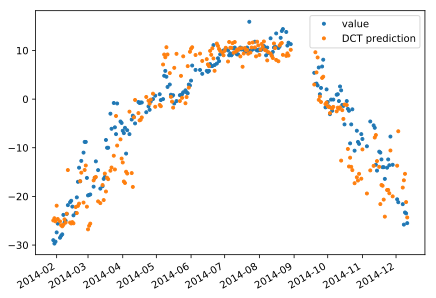

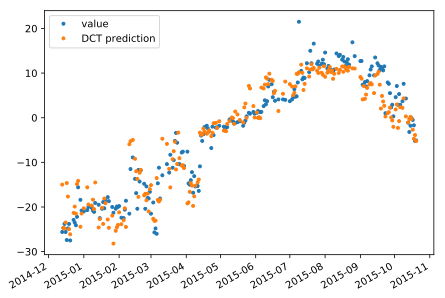

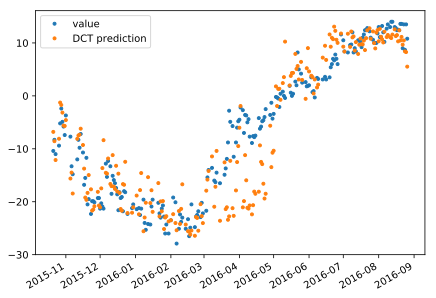

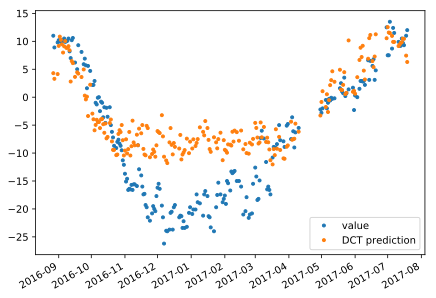

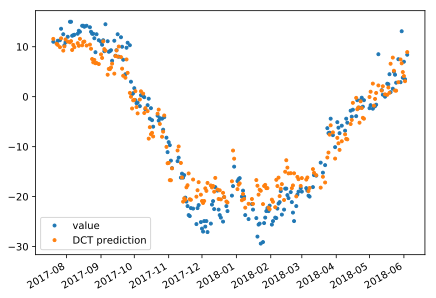

In [28]:
from scipy.fftpack import dct, idct

def dct_(X):
    N = X.shape[0]
    y = X[[cn.value]]
    y.reset_index(inplace=True)
    
    Y = dct(y[[cn.value]].values, norm='ortho')
    index = np.fft.fftfreq(N)
    
    dct_target = pd.DataFrame(np.hstack((Y)), columns=['dct']) 
    dct_target.loc[:, cn.date] = y['index']
    dct_target.set_index(index, inplace=True)
    dct_X = X.set_index(index)
    
    return dct_X, dct_target

def predict_dct():
    
    params = {
#         'verbosity':0,
        'max_depth': 5,

#         'learning_rate': 0.09,
#         'min_child_weight': 6,
#         'subsample':0.8, 
    #     'colsample_bytree':0.8,
    #     'gamma': 12,
    }

    dct_X, dct_target = dct_(X)
    dct_X.drop([cn.value], inplace=True, axis=1)
    real_X, real_target = mix.getTarget(X)

    for train_index, test_index in TimeSeriesSplit(5).split(dct_X):
#         test_index = [i for i in range(0, dct_X.shape[0]) if i not in train_index]  

        dct_X_train, dct_X_test = dct_X.iloc[train_index], dct_X.iloc[test_index]
        dct_target_train, dct_target_test = dct_target.iloc[train_index], dct_target.iloc[test_index]
        print("Train size : {} and test size : {}".format(dct_X_train.shape[0], dct_X_test.shape[0]))

        real_target_train = real_target.loc[dct_target_train[cn.date]]
        real_target_test = real_target.loc[dct_target_test[cn.date]]

        reg = xgb.XGBRegressor(**params)
        reg.fit(dct_X_train, dct_target_train.loc[:, 'dct'])
        dct_target_test['Predict dct'] = reg.predict(dct_X_test)
        dct_target_train['Predict dct'] = reg.predict(dct_X_train)

        Y = dct_target_train[['Predict dct']].values
        real_target_train['DCT prediction'] = idct(Y, norm='ortho')

        Y = dct_target_test[['Predict dct']].values
        real_target_test['DCT prediction'] = idct(Y, norm='ortho')

        mix.print_mean(real_target_test, real_target_train, cn.value, 'DCT prediction')
        real_target_test.plot(style=".")

predict_dct()